In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
varname='pr'
varlev='sfc'
dataset='CPC-PRECIP'

basepath='/shared/subx/'
modelpath=basepath+'hindcast/'+varname+varlev+'/daily/anoms/'
verifpath=basepath+'verif/prsfc/daily/anoms/'+dataset+'/'
file_stub='_*.anoms.daily'
ofname='all_models_accperfect_CONUS_giorgi.1-12.nc'
figname='all_models_accperfect_CONUS_giorgi.1-12.png'

gregions=['ENA','CNA','WNA']
gregnums=[5,6,7]

smoothlist=[1,7,14,21,28,30]
smoothcolors=['k','r','b','g','y','c']

In [4]:
groups=['ECCC','ESRL','NCEP','RSMAS',
        'EMC','GMAO','NRL','CESM','CESM']

models=['GEM','FIMr1p1','CFSv2','CCSM4',
       'GEFS','GEOS_V2p1','NESM','46LCESM1',
       '30LCESM1']
nenss=[4,4,4,4,11,4,1,10,10]

In [5]:
ds_gmask=utils.getGiorgiMask()

In [6]:
all_list=[]

for i,(group,model) in enumerate(zip(groups,models)):

    print(group,model)
    
    # Get Giorgi Regions for SubX Models Ensemble Mean
    ds_giorgi_emean=utils.getSubXModelGiorgi(modelpath,model,
                                             group,varname,varlev,
                                             file_stub,ds_gmask,
                                             gregions,gregnums)
    
    # Get Giorgi Regions for SubX Model Ensemble Members
    ens_list=[]
    for iens in np.arange(nenss[i]):
        file_stub_emem=file_stub+'.e'+str(iens+1)
        emem_tmp=utils.getSubXModelGiorgi(modelpath,model,
                                          group,varname,varlev,
                                          file_stub_emem,ds_gmask,
                                          gregions,gregnums)
        ens_list.append(emem_tmp)
    
    # Combine the ensemble members into ens dimension
    ds_giorgi_emem=xr.combine_nested(ens_list,concat_dim='ens')
    
    # Drop missing ICs before doing skill calculations
    # Move this to skill function
    ds_giorgi_emem=ds_giorgi_emem.dropna(dim='ic',how='all')
    ds_giorgi_emean=ds_giorgi_emean.dropna(dim='ic',how='all')

    # Calculate sliding perfect model skill
    skill_tmp=utils.calcPerfectSliding(ds_giorgi_emean,
                                       ds_giorgi_emem,
                                       gregions,smoothlist)
    
    # Combine the sliding skill together into a dimension
    tmp=xr.combine_nested(skill_tmp,concat_dim='swin').compute()
    
    # Add the sliding window skill to the giant list for this model
    all_list.append(tmp)

ECCC GEM


#### Put all models together

In [7]:
all_models=xr.combine_nested(all_list,concat_dim='model')
all_models['model']=models
all_models['swin']=smoothlist
all_models=all_models.persist()
all_models

<xarray.Dataset>
Dimensions:  (model: 1, swin: 6, time: 32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * model    (model) <U3 'GEM'
  * swin     (swin) int64 1 7 14 21 28 30
Data variables:
    ENA      (model, swin, time) float32 0.9977906 0.9990338 ... nan nan
    CNA      (model, swin, time) float32 0.9986784 0.998787 ... nan nan
    WNA      (model, swin, time) float32 0.9984555 0.99953324 ... nan nan

#### Write data to file

In [8]:
all_models.to_netcdf(ofname)

#### Plot

0 ENA
1 CNA
2 WNA


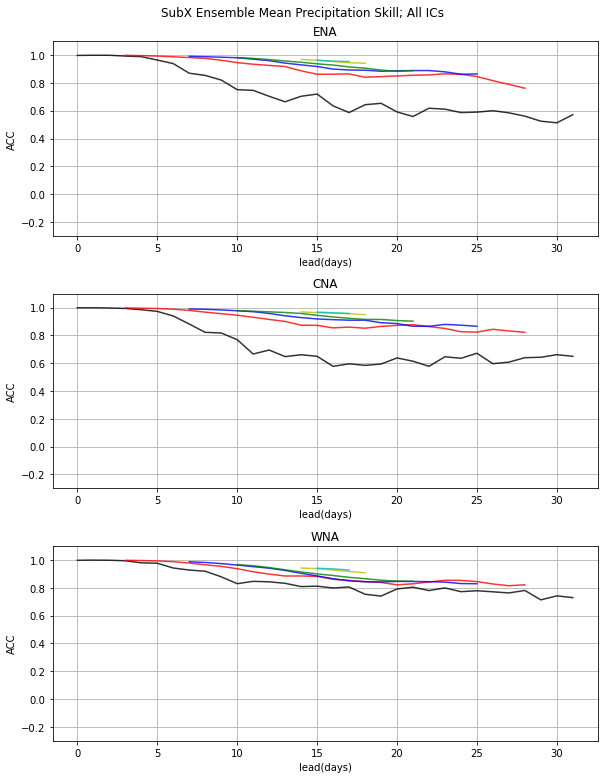

In [9]:
utils.plotSlidingCorrs(all_models,models,gregions,
                       smoothcolors,smoothlist,figname)


fig=plt.figure(figsize=(8.5,11))

for i,reg in enumerate(gregions):
    print(i,reg)
    
    plt.subplot(3,1,i+1)

    for iwin,(c,w) in enumerate(zip(smoothcolors,smoothlist)):
        
            # Plot each model
            for imodel,m in enumerate(models):
                plt.plot(all_models['time'],
                         all_models[reg][imodel,iwin,:].T,
                         color=c,linestyle='-',alpha=0.8)  
